In [2]:
client_id = "NjCkeE5n21b4IPWLlbAi"
client_secret = "J6RWn6YJz8"


[✓] 시차별 상관관계:
    Lag  Correlation
0    -3     0.451128
1    -2     0.495308
2    -1     0.555559
3     0     0.592755
4     1     0.493655
5     2     0.430029
6     3     0.382114
7     4     0.293804
8     5     0.326326
9     6     0.294021
10    7     0.214062

[🎯] 가장 높은 상관관계: lag 0일, 상관계수 = 0.5928


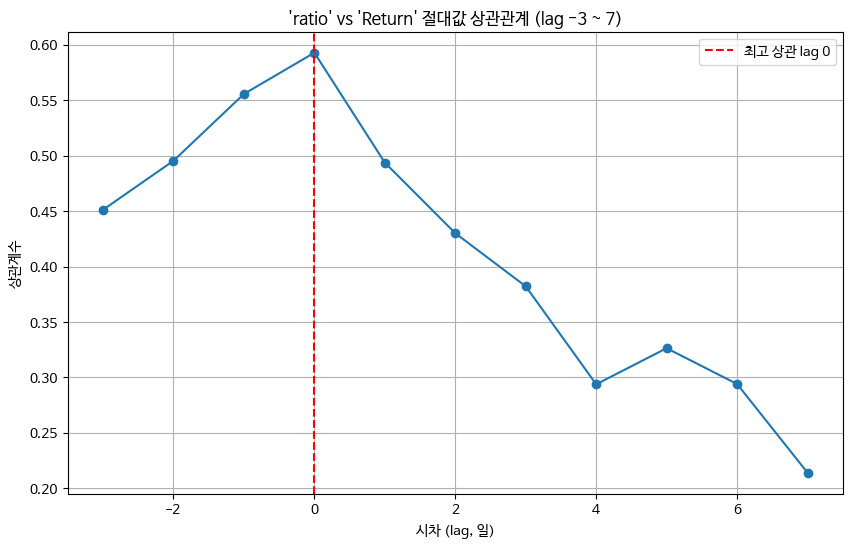

In [3]:
"""
네이버 검색 트렌드와 KRX 주가 수익률의 시차 상관관계 분석
"""
import json
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from datetime import datetime

# ======================= 네이버 트렌드 데이터 함수 =======================
def get_naver_trend_data(keywords, start_date, end_date):
    url = "https://openapi.naver.com/v1/datalab/search"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret,
        "Content-Type": "application/json",
    }
    body = {
        "startDate": start_date,
        "endDate": end_date,
        "timeUnit": "date",
        "keywordGroups": [{"groupName": keywords[0], "keywords": keywords}],
        "device": "pc"
    }

    req = urllib.request.Request(url, data=json.dumps(body).encode("utf-8"))
    for k, v in headers.items():
        req.add_header(k, v)

    try:
        with urllib.request.urlopen(req) as response:
            if response.getcode() == 200:
                response_text = response.read().decode("utf-8")
                data_json = json.loads(response_text)
                data_list = data_json['results'][0]['data']
                df = pd.DataFrame(data_list)
                df['날짜'] = pd.to_datetime(df['period'])
                df.drop(columns='period', inplace=True)
                df.set_index('날짜', inplace=True)
                return df
            else:
                raise Exception(f"Error Code: {response.getcode()}")
    except Exception as e:
        print(f"[Error] {e}")
        return pd.DataFrame()

# ======================= KRX 주가 수익률 함수 =======================
def get_daily_returns(ticker, start_date="2022-01-01", end_date=None, save_csv=True):
    if end_date is None:
        end_date = datetime.today().strftime("%Y-%m-%d")
    df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
    df['Return'] = df['종가'].shift(1) / df['종가'] - 1
    df.reset_index(inplace=True)
    df = df[['날짜', '종가', 'Return']]
    if save_csv:
        filename = f"{ticker}_2days_later_return.csv"
        df.to_csv(filename, index=False)
        print(f"[✓] Saved to {filename}")
    return df

# ======================= 상관관계 분석 함수 =======================
def lagged_correlation_analysis_return_ratio(df, ratio_col='ratio', return_col='Return', date_col='날짜', min_lag=-3, max_lag=7):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    lag_results = []

    for lag in range(min_lag, max_lag + 1):
        temp_df = df.copy()
        temp_df[f'{return_col}_lag_{lag}'] = temp_df[return_col].shift(-lag).abs()
        clean_df = temp_df.dropna(subset=[ratio_col, f'{return_col}_lag_{lag}'])
        corr = clean_df[ratio_col].corr(clean_df[f'{return_col}_lag_{lag}'])
        lag_results.append({'Lag': lag, 'Correlation': corr})

    lag_corr_df = pd.DataFrame(lag_results)
    best_row = lag_corr_df.loc[lag_corr_df['Correlation'].abs().idxmax()]

    print("\n[✓] 시차별 상관관계:")
    print(lag_corr_df)
    print(f"\n[🎯] 가장 높은 상관관계: lag {int(best_row['Lag'])}일, 상관계수 = {best_row['Correlation']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(lag_corr_df['Lag'], lag_corr_df['Correlation'], marker='o', linestyle='-')
    plt.axvline(best_row['Lag'], color='red', linestyle='--', label=f"최고 상관 lag {int(best_row['Lag'])}")
    plt.title(f"'{ratio_col}' vs '{return_col}' 절대값 상관관계 (lag {min_lag} ~ {max_lag})")
    plt.xlabel("시차 (lag, 일)")
    plt.ylabel("상관계수")
    plt.legend()
    plt.grid(True)
    plt.show()

    return lag_corr_df, best_row

# ======================= 예시 실행 =======================
if __name__ == "__main__":
    client_id = client_id     # 여기에 본인 ID 입력
    client_secret = client_secret # 여기에 본인 Secret 입력

    start_date = "2024-06-23"
    end_date = "2025-06-23"
    keywords = ["상지건설"]
    ticker = "042940"  # 상지건설 티커

    # 네이버 검색 비율
    trend_df = get_naver_trend_data(keywords, start_date, end_date)
    trend_df.rename(columns={'ratio': 'ratio'}, inplace=True)
    trend_df.reset_index(inplace=True)

    # 주가 수익률
    return_df = get_daily_returns(ticker, start_date=start_date, save_csv=False)

    # 날짜 통일 후 병합
    trend_df['날짜'] = pd.to_datetime(trend_df['날짜'])
    return_df['날짜'] = pd.to_datetime(return_df['날짜'])
    merged_df = pd.merge(return_df, trend_df, on='날짜', how='inner')

    # 시차 분석
    lagged_correlation_analysis_return_ratio(merged_df, ratio_col='ratio', return_col='Return')